In [ ]:
!pip install yfinance

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

### Download Stock Data

In [3]:
ticker = "TCS.NS"

data = yf.download(ticker, start="2018-01-01", end="2024-01-01")

if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

print(data.columns)
data.head()

/tmp/ipython-input-3003154762.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2018-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed

Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')


Price,Close,High,Low,Open,Volume
Date,,,,,
2018-01-01,1083.771240,1103.926022,1079.428906,1098.805391,1351760
2018-01-02,1077.872437,1093.603077,1073.366281,1089.670392,1920290
2018-01-03,1080.924561,1093.357497,1077.872683,1078.200424,1257120
2018-01-04,1088.482178,1090.489425,1081.477116,1085.573620,913082
2018-01-05,1101.631836,1105.851255,1085.573560,1085.573560,1153706


### Visualize Stock Price

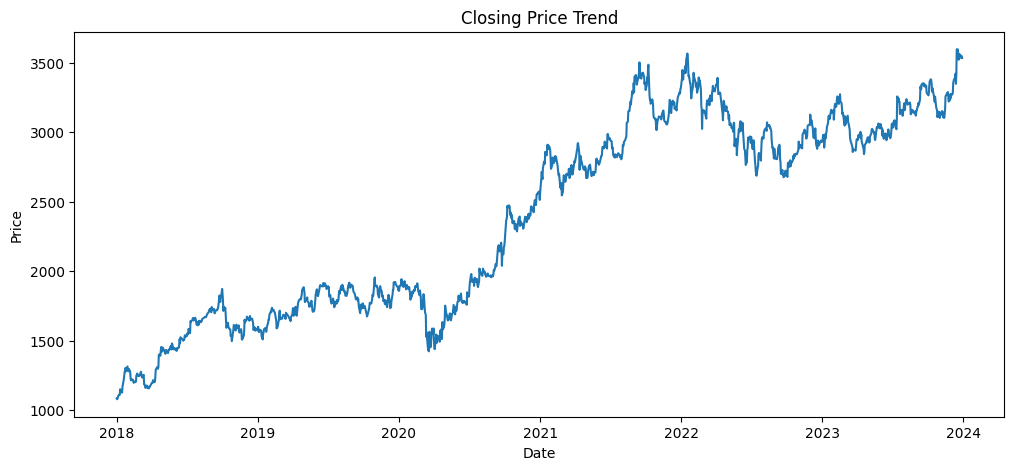

In [4]:
plt.figure(figsize=(12,5))
plt.plot(data['Close'])
plt.title("Closing Price Trend")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

### Create Target (UP/DOWN Label)

In [5]:
data['Tomorrow'] = data['Close'].shift(-1)
data['Target'] = (data['Tomorrow'] > data['Close']).astype(int)

data = data.dropna()

data[['Close','Tomorrow','Target']].head()

Price,Close,Tomorrow,Target
Date,,,
2018-01-01,1083.771240,1077.872437,0
2018-01-02,1077.872437,1080.924561,1
2018-01-03,1080.924561,1088.482178,1
2018-01-04,1088.482178,1101.631836,1
2018-01-05,1101.631836,1111.955200,1


### Scaling Data

In [6]:
scaler = MinMaxScaler()
scaled_close = scaler.fit_transform(data[['Close']])

### Create Time Sequences (30 Days)

In [7]:
sequence_length = 30

X = []
y = []

for i in range(sequence_length, len(scaled_close)):
    X.append(scaled_close[i-sequence_length:i])
    y.append(data['Target'].values[i])

X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1450, 30, 1)
y shape: (1450,)


### Train/Test Split

In [8]:
split = int(len(X)*0.8)

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(X_train.shape, X_test.shape)

(1160, 30, 1) (290, 30, 1)


### Build LSTM Model

In [9]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(30,1)),
    Dropout(0.2),
    LSTM(32),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

### Train Model

In [10]:
history = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test,y_test)
)

Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - accuracy: 0.5249 - loss: 0.6947 - val_accuracy: 0.5103 - val_loss: 0.6951
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.5465 - loss: 0.6901 - val_accuracy: 0.5103 - val_loss: 0.6932
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5555 - loss: 0.6901 - val_accuracy: 0.5103 - val_loss: 0.6928
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5685 - loss: 0.6895 - val_accuracy: 0.5103 - val_loss: 0.6929
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5186 - loss: 0.6913 - val_accuracy: 0.5103 - val_loss: 0.6929
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5256 - loss: 0.6916 - val_accuracy: 0.5103 - val_loss: 0.6939
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5458 - loss: 0.6896 - val_accuracy: 0.5103 - val_loss: 0.6934
Epoch 8/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5456 - loss: 0.6896 - val_accuracy: 0.5103 - v

### Training Visualization

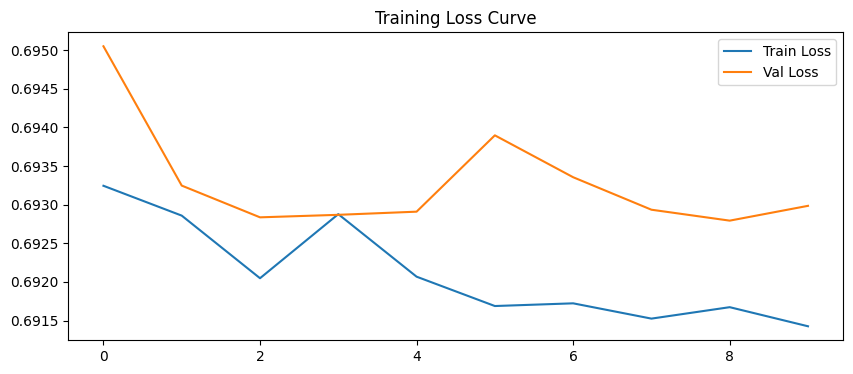

In [11]:
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Training Loss Curve")
plt.show()

### Predict UP/DOWN

In [12]:
pred_probs = model.predict(X_test)
preds = (pred_probs > 0.5).astype(int)

print(preds[:10])

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]]


### Prediction Visualization

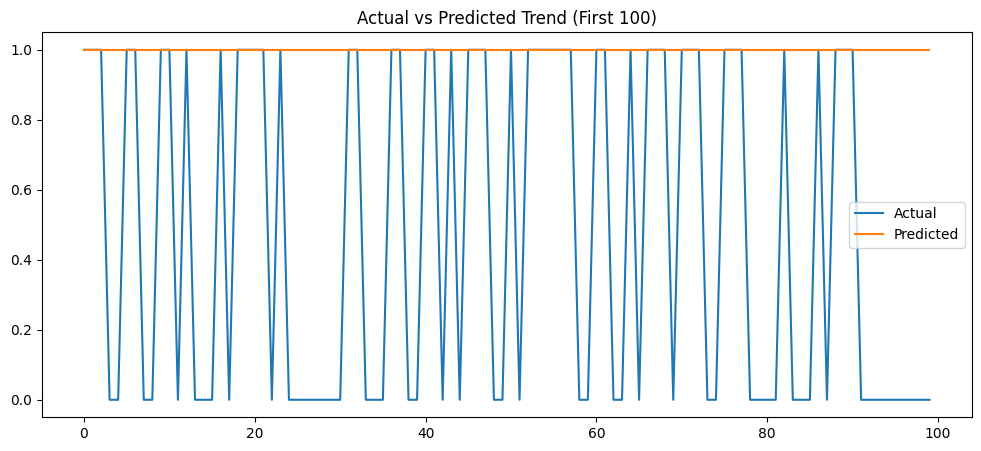

In [13]:
plt.figure(figsize=(12,5))
plt.plot(y_test[:100], label="Actual")
plt.plot(preds[:100], label="Predicted")
plt.legend()
plt.title("Actual vs Predicted Trend (First 100)")
plt.show()

### Accuracy Score

In [14]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, preds)
print("Model Accuracy:", accuracy)

Model Accuracy: 0.5103448275862069
